## Settings

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import os
import sys

import numpy as np
import pandas as pd
from plotnine import * ## ggplot for python

from sklearn.metrics import mean_squared_error
from hyperopt import fmin, hp, tpe

from dtw import *

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [3]:
if not 'covid' in os.listdir():
    sys.path.append('..')
    
import covid

## Loading

In [4]:
from covid.dataset import fetch_daily_case

In [5]:
data = fetch_daily_case(update=True, return_data=True)

In [6]:
data = (
    data
    .query('source_nom == "Ministère des Solidarités et de la Santé"')
    .query('granularite == "pays"')
)

## Visualize

In [7]:
data['date'] = pd.to_datetime(data['date'])
data['week'] = data['date'].dt.week

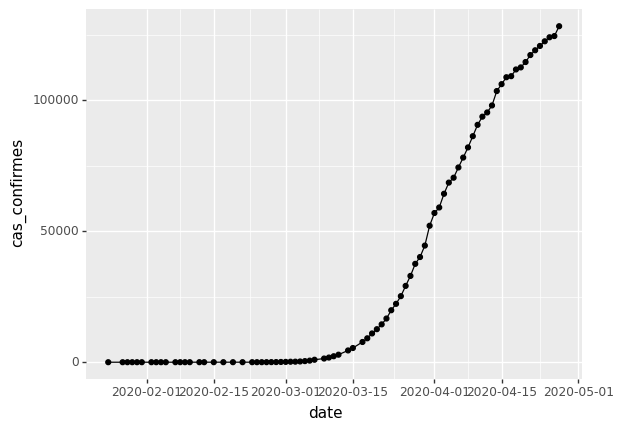

<ggplot: (-9223371922104703908)>

In [14]:
(
    ggplot(data)
    + aes(x='date', y='cas_confirmes')
    + geom_line()
    + geom_point()
)

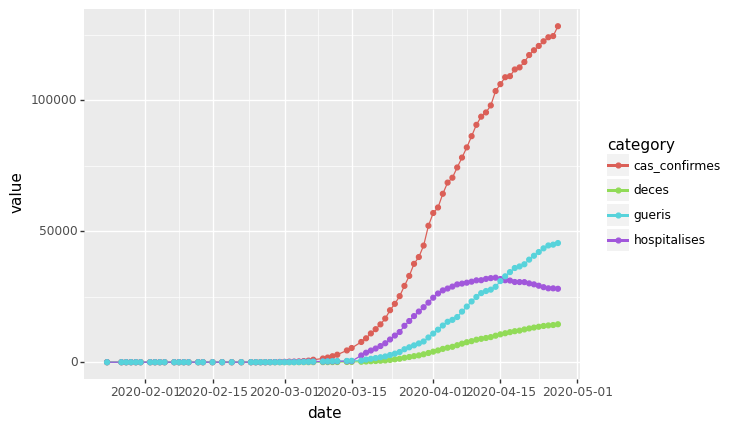

<ggplot: (-9223371922104703844)>

In [15]:
data_ = (
    data
    .filter(['date', 'cas_confirmes', 'deces', 'hospitalises', 'gueris'])
    .melt(id_vars=['date'], var_name='category', value_name='value')
)

(
    ggplot(data_)
    + aes(x='date', y='value', color='category')
    + geom_line()
    + geom_point()
)

## Inference

### Define constants

In [16]:
from covid.models import SIR, SEIDR

In [17]:
N = 6.5e7

start_date = data['date'].min()
end_date = data['date'].max()

dates = data['date']

data['gueris'] = data['gueris'].interpolate().fillna(0)
data['cas_confirmes'] = data['cas_confirmes'].interpolate().fillna(0)
data['hospitalises'] = data['hospitalises'].interpolate().fillna(0)
data['deces'] = data['deces'].interpolate().fillna(0)

### SIR

In [18]:
gamma_0 = 1/4
R0 = 5
beta_0 = gamma_0 * R0 
start = (beta_0, gamma_0)

I0 = 2
init_state = (N-I0, I0, 0)

In [31]:
def fun_sir(x):
    beta, gamma = x

    model = SIR(N, beta, gamma)
    res = model.solve(init_state, start_date=start_date)
    
    r_pred = res.loc[dates, 'R']
    i_pred = res.loc[dates, 'I']
    
    return np.sqrt(
#         mean_squared_error(r_pred, data['gueris']) + \
        mean_squared_error(i_pred, data['cas_confirmes'])
    )

In [2]:
spaces_sir = (
    hp.normal('beta', 0.5, 0.3),
    hp.uniform('gamma', 0.5, 3)
)

NameError: name 'hp' is not defined

In [1]:
type(spaces_sir[0])

NameError: name 'spaces_sir' is not defined

In [36]:
def solve(fun, spaces, max_evals=1000):
    best = fmin(
        fn=fun,
        space=spaces,
        algo=tpe.suggest,
        max_evals=max_evals
    )
    return best

In [37]:
best_sir = solve(fun_sir, spaces_sir)

100%|████████████████████████████████████████████| 1000/1000 [02:29<00:00,  6.69trial/s, best loss: 29899.929185244317]


In [39]:
print(best_sir)

{'beta': 0.9676194761038474, 'gamma': 0.842677018408921}


In [41]:
model_sir = SIR(N, best_sir["beta"], best_sir["gamma"])
res_sir = model_sir.solve(init_state, start_date = start_date)

In [42]:
data_merge = (
    data
    .filter(['date', 'cas_confirmes', 'deces', 'gueris', 'hospitalises'])
    .merge(
        res_sir.reset_index(), 
        left_on='date', 
        right_on='index',
        how='left'
    )
    .melt(
        id_vars='date', 
        value_vars=['gueris', 'cas_confirmes', 'R', 'I'], 
        var_name='var', 
        value_name='value'
    )
)

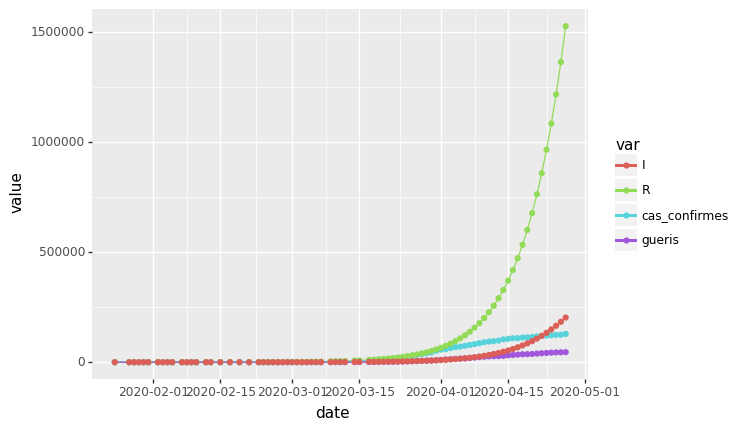

<ggplot: (-9223371922104524964)>

In [44]:
g = (
    ggplot(data_merge)
    + aes(x='date', y='value', color='var')
    + geom_line()
    + geom_point()
)

g

### SEIDIR

In [45]:
delta = 1/3 # Incubation time = 3 days
alpha = 0.2 # probability to die
rho = 1/9 # 9 ndays before death 

In [46]:
def fun_seidr(x):
    beta, R0, I0 = x
    
    gamma = beta * R0
    
    init_state_seidr = (N - I0, I0, 0, 0, 0)

    model = SEIDR(N, beta=beta, delta=delta, gamma=gamma, rho=rho, alpha=alpha)
    res = model.solve(init_state_seidr, start_date=start_date)
    
    r_pred = res.loc[dates, 'R']
    i_pred = res.loc[dates, 'I']
    d_pred = res.loc[dates, 'D']
    
    return np.sqrt(
        mean_squared_error(r_pred, data['gueris']) + \
        mean_squared_error(d_pred, data['deces'])  + \
        mean_squared_error(i_pred, data['cas_confirmes'])
    )

In [54]:
spaces_seidr = (
    hp.normal('beta', 0.8, 0.1),
    hp.normal('R0', 3.31, 0.3),
    hp.normal('I0', 15.8, 6)
)

In [55]:
best_seidr = solve(fun_seidr, spaces_seidr)

print(best_seidr)

 25%|███████████▌                                  | 251/1000 [01:28<07:25,  1.68trial/s, best loss: 42540.74915985809]

C:\Users\leo.grosjean\AppData\Local\Continuum\anaconda3\envs\covid\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning:

Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.




 29%|█████████████▎                                | 290/1000 [01:39<06:57,  1.70trial/s, best loss: 38169.41307330639]

C:\Users\leo.grosjean\AppData\Local\Continuum\anaconda3\envs\covid\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning:

Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.




 30%|█████████████▋                                | 298/1000 [01:42<06:35,  1.77trial/s, best loss: 38169.41307330639]

C:\Users\leo.grosjean\AppData\Local\Continuum\anaconda3\envs\covid\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning:

Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.




 31%|██████████████                                | 306/1000 [01:46<07:36,  1.52trial/s, best loss: 38169.41307330639]

C:\Users\leo.grosjean\AppData\Local\Continuum\anaconda3\envs\covid\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning:

Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.




 34%|████████████████                               | 343/1000 [01:58<06:35,  1.66trial/s, best loss: 37978.8387004216]

C:\Users\leo.grosjean\AppData\Local\Continuum\anaconda3\envs\covid\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning:

Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.




 35%|████████████████▌                              | 352/1000 [02:01<05:51,  1.84trial/s, best loss: 37978.8387004216]

C:\Users\leo.grosjean\AppData\Local\Continuum\anaconda3\envs\covid\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning:

Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.




 39%|█████████████████▊                            | 387/1000 [02:11<05:38,  1.81trial/s, best loss: 36998.86118326133]

C:\Users\leo.grosjean\AppData\Local\Continuum\anaconda3\envs\covid\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning:

Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.




 39%|██████████████████                            | 394/1000 [02:14<06:09,  1.64trial/s, best loss: 36998.86118326133]

C:\Users\leo.grosjean\AppData\Local\Continuum\anaconda3\envs\covid\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning:

Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.




 40%|██████████████████▎                           | 398/1000 [02:16<06:33,  1.53trial/s, best loss: 36998.86118326133]

C:\Users\leo.grosjean\AppData\Local\Continuum\anaconda3\envs\covid\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning:

Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.




 44%|████████████████████                          | 437/1000 [02:28<04:49,  1.94trial/s, best loss: 36998.86118326133]

C:\Users\leo.grosjean\AppData\Local\Continuum\anaconda3\envs\covid\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning:

Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.




 47%|█████████████████████▋                        | 472/1000 [02:38<05:02,  1.75trial/s, best loss: 36998.86118326133]

C:\Users\leo.grosjean\AppData\Local\Continuum\anaconda3\envs\covid\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning:

Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.




 48%|█████████████████████▉                        | 476/1000 [02:40<05:20,  1.64trial/s, best loss: 36998.86118326133]

C:\Users\leo.grosjean\AppData\Local\Continuum\anaconda3\envs\covid\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning:

Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.




 48%|██████████████████████▏                       | 481/1000 [02:43<05:38,  1.53trial/s, best loss: 36998.86118326133]

C:\Users\leo.grosjean\AppData\Local\Continuum\anaconda3\envs\covid\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning:

Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.




100%|██████████████████████████████████████████████| 1000/1000 [05:01<00:00,  3.32trial/s, best loss: 29319.0077149361]
{'I0': 17.579630921217127, 'R0': 0.19700250987075502, 'beta': 0.21307984295138285}


In [56]:
seidr = SEIDR(N, beta=best_seidr['beta'], delta=delta, gamma=best_seidr['beta']*best_seidr['R0'], rho=rho, alpha=alpha)

In [57]:
init_state_seidr = (N - best_seidr['I0'], best_seidr['I0'], 0, 0, 0)

data_pred = (
    seidr.solve(init_state_seidr, start_date = start_date)
    .filter(['I', 'D', 'R', 'type'])
    .assign(type='pred')
    .reset_index()
)

In [58]:
data_true = (
    data
    .filter(['date', 'cas_confirmes', 'deces', 'gueris'])
    .rename(columns={'date': 'index', 'cas_confirmes': 'I', 'deces': 'D', 'gueris': 'R'})
    .assign(type='true')
)

In [59]:
data_all = (
    pd.concat([data_pred, data_true])
    .melt(
        id_vars=['index', 'type'], 
        value_vars=['I', 'D', 'R'], 
        var_name='var', 
        value_name='value'
    )
    .query("index < @end_date")
)

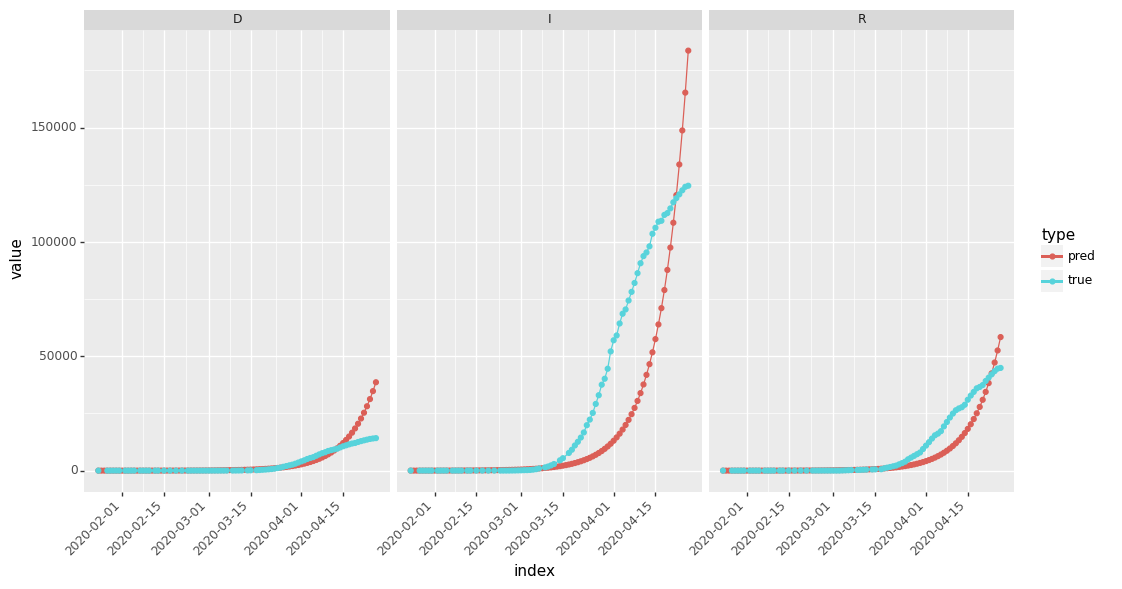

<ggplot: (-9223371922104354552)>

In [60]:
(
    ggplot(data_all)
    + aes(x='index', y='value', color='type')
    + geom_line()
    + geom_point()
    + facet_wrap('var')
    + theme(
        figure_size=(12, 6), 
        axis_text_x=element_text(rotation=45, hjust=1)
    )
)

### SEIHDR 

In [61]:
from covid.models import SEIHDR
from covid.policies.utils import multiple_sigmoid_response
from datetime import date

In [166]:
lockdown_start_date = date(2020, 3, 17)
lockdown_end_date = date(2020, 5, 11)

start_date_dt = date(start_date.year, start_date.month, start_date.day)

lockdown_after = (lockdown_start_date - start_date_dt).days

# lockdown_implementation_days = 6

exit = (lockdown_end_date - start_date_dt).days

In [167]:
spaces_seihdr = (
#     hp.normal('beta', 0.5, 0.3),
    hp.normal('R0', 3.31, 0.3),
    hp.normal('R1', 0.5, 0.3),
    hp.normal('I0', 15.8, 6),
    hp.uniformint('lockdown_implementation_days', 3, 7)
)

In [168]:
gamma = 1/4 # rate of infection
delta = 1/3 # incubation time
theta = 1/5 # ndays before complication
kappa = 1/10 # ndays before symptoms disappear
phi = 0.5 # probability of complications
alpha = 0.2 # probability to die
rho = 1/9 # 9 ndays before death

In [189]:
def error(y_pred, y_true):
    return mean_squared_error(y_pred, y_true)/(np.max(y_true)**2)

def error_dtw(y_pred, y_true):
    alignment = dtw(y_pred,y_true,distance_only=True)
    return alignment.distance

def error_date(y_pred, y_true):
    max_pred = np.max(y_pred.values)
    max_true = np.max(y_true)
    argmax_pred = np.argmax(y_pred.values)
    argmax_true = np.argmax(y_true)
    return ((max_pred-max_true)/max_true)**2 + ((argmax_pred-argmax_true)/argmax_true)**2

In [200]:
def fun_seihdr(x):
    R0, R1, I0, lockdown_implementation_days = x
    
    beta_high = gamma * R0
    beta_low = gamma * R1
    betas = [beta_low,beta_high]
    
    def beta_lockdown(y,t,exit):
        return multiple_sigmoid_response(t,beta_high,betas,[lockdown_after,exit],lockdown_implementation_days)
    
    init_state_seihdr = (N - I0, I0, 0, 0, 0, 0)

    model = SEIHDR(
        N, 
        beta=lambda y,t : beta_lockdown(y,t,exit), 
        delta=delta, 
        gamma=gamma, 
        rho=rho, 
        alpha=alpha,
        theta=theta,
        phi=phi,
        kappa=kappa
    )
    res = model.solve(init_state_seihdr, start_date=start_date)
    
    i_pred = res.loc[dates, 'I']
    h_pred = res.loc[dates, 'H']
    d_pred = res.loc[dates, 'D']
    r_pred = res.loc[dates, 'R']
    
    return np.sqrt(
        error_date(r_pred, data['gueris']) + \
        error_date(d_pred, data['deces'])  + \
        error_date(h_pred, data['hospitalises'])  # + \
#         error_date(i_pred, data['cas_confirmes'])
    )

In [201]:
best_seihdr = fmin(
    fn=fun_seihdr,
    space=spaces_seihdr,
    algo=tpe.suggest,
    max_evals=500)

print(best_seihdr)

  0%|                                                | 1/500 [00:01<08:48,  1.06s/trial, best loss: 1360.7558009347456]

C:\Users\leo.grosjean\AppData\Local\Continuum\anaconda3\envs\covid\lib\site-packages\numpy\core\fromnumeric.py:61: FutureWarning:


The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.




100%|██████████████████████████████████████████████| 500/500 [08:45<00:00,  1.05s/trial, best loss: 1.9047968494374994]
{'I0': 24.77345375206478, 'R0': 0.6208912021997555, 'R1': 2.6256871246441134, 'lockdown_implementation_days': 5.0}


In [202]:
beta_high = gamma * best_seihdr['R0']
beta_low = gamma * best_seihdr['R1']
betas = [beta_low,beta_high]

def beta_lockdown(y,t,exit):
    return multiple_sigmoid_response(t,beta_high,betas,[lockdown_after,exit],lockdown_implementation_days)

seihdr = SEIHDR(
        N, 
        beta=lambda y,t : beta_lockdown(y,t,exit), 
        delta=delta, 
        gamma=gamma, 
        rho=rho, 
        alpha=alpha,
        theta=theta,
        phi=phi,
        kappa=kappa
    )

In [203]:
t = seihdr.solve(init_state_seihdr, start_date = start_date)

In [209]:
init_state_seihdr = (N - best_seihdr['I0'], best_seihdr['I0'], 0, 0, 0, 0)

data_pred_seihdr = (
    seihdr.solve(init_state_seihdr, start_date = start_date, n_days=365)
    .filter(['I', 'D', 'R', 'H'])
    .assign(type='pred')
    .reset_index()
)

In [210]:
data_true_seihdr = (
    data
    .filter(['date', 'cas_confirmes', 'deces', 'gueris', 'hospitalises'])
    .rename(columns={'date': 'index', 'cas_confirmes': 'I', 'deces': 'D', 'gueris': 'R', 'hospitalises': 'H'})
    .assign(type='true')
)

In [211]:
data_all_seihdr = (
    pd.concat([data_pred_seihdr, data_true_seihdr])
    .melt(
        id_vars=['index', 'type'], 
        value_vars=['I', 'D', 'R', 'H'], 
        var_name='var', 
        value_name='value'
    )
    .query("index <= @end_date")
)

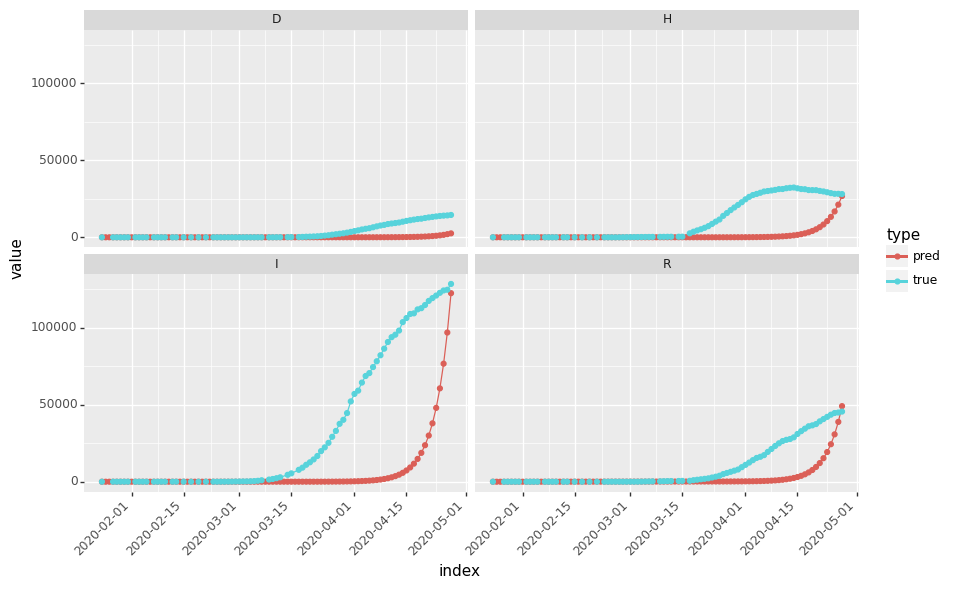

<ggplot: (-9223371922099645236)>

In [212]:
(
    ggplot(data_all_seihdr)
    + aes(x='index', y='value', color='type')
    + geom_line()
    + geom_point()
    + facet_wrap('var')
    + theme(
        figure_size=(10, 6), 
        axis_text_x=element_text(rotation=45, hjust=1)
    )
)

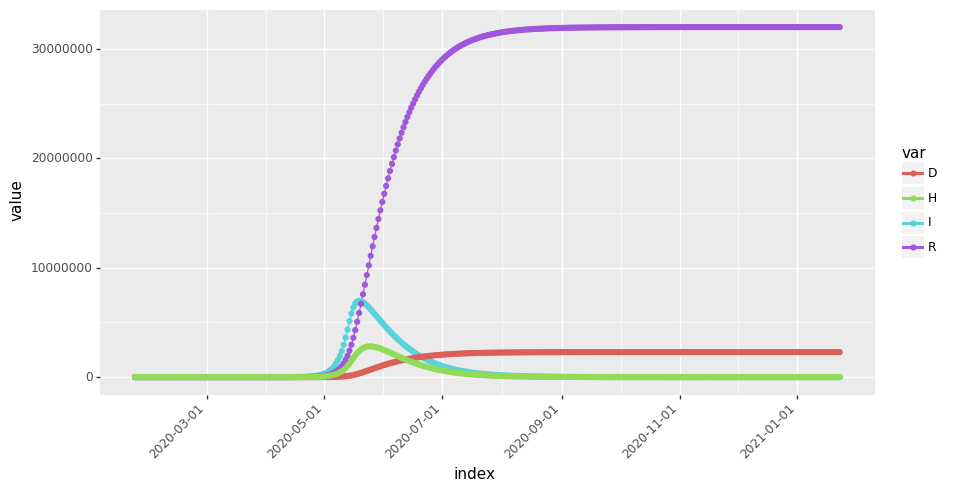

<ggplot: (-9223371922102176080)>

In [213]:
(
    ggplot(
        data_pred_seihdr
        .melt(
            id_vars=['index'], 
            value_vars=['I', 'D', 'R', 'H'], 
            var_name='var', 
            value_name='value'
        )
    )
    + aes(x='index', y='value', color='var')
    + geom_line()
    + geom_point()
    + theme(
        figure_size=(10, 5), 
        axis_text_x=element_text(rotation=45, hjust=1)
    )
)